In [4]:
import imp
import ppsim as pp
imp.reload(pp)
from dataclasses import dataclass
import dataclasses
import numpy as np
from matplotlib import pyplot as plt
import pickle

import ipywidgets as widgets

# CRN (chemical reaction network) notation for specifying protocols



In [17]:
# CRN for approximate majority

a,b,u = pp.species('A B U')
approx_majority = [
    a+b >> 2*u,
    a+u >> 2*a,
    b+u >> 2*b,
]

 Time: 27.800


(0.0, 100000.0)

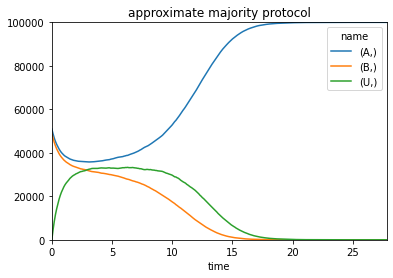

In [18]:
n = 10 ** 5
init_config = {a: 0.51*n, b: 0.49*n}
sim = pp.Simulation(init_config, approx_majority)
sim.run(recording_step=0.1)
sim.history.plot()
plt.title('approximate majority protocol')
plt.xlim(0, sim.times[-1])
plt.ylim(0, n)